
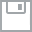
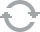
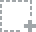
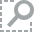
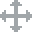
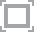
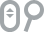
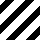
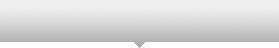
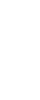
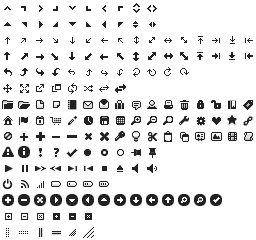
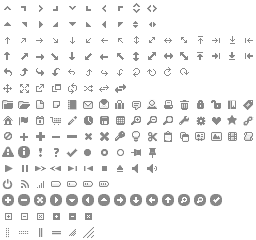
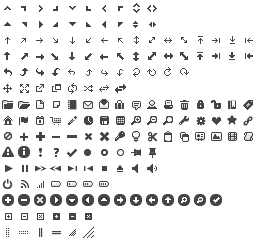
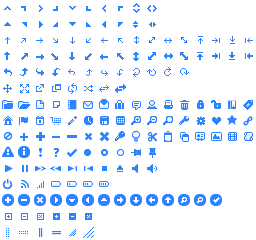
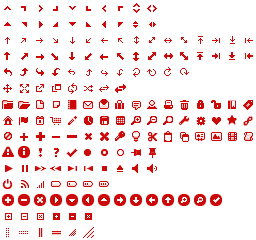
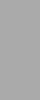
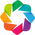
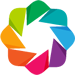

In [1]:
import warnings

# Our numerical workhorses
import numpy as np
import pandas as pd

#Differential equation numerical solver
from scipy.integrate import odeint

# Import pyplot for plotting
import matplotlib.pyplot as plt
import mpl_toolkits.mplot3d

# Seaborn, useful for graphics
import seaborn as sns

# To compute symbolic expressions
import sympy
# print outputs in LaTeX
sympy.init_printing(use_unicode=True) 

# Interactive manipulations in the notebook
# from ipywidgets import StaticInteract, RangeWidget, RadioWidget
from ipywidgets import interact

# Magic function to make matplotlib inline; other style specs must come AFTER
%matplotlib inline

# This enables SVG graphics inline.  There is a bug, so uncomment if it works.
%config InlineBackend.figure_formats = {'png', 'retina'}

# JB's favorite Seaborn settings for notebooks
rc = {'lines.linewidth': 2, 
      'axes.labelsize': 18, 
      'axes.titlesize': 18, 
      'axes.facecolor': 'DFDFE5'}
sns.set_context('notebook', rc=rc)
sns.set_style('darkgrid', rc=rc)

# Import Bokeh modules for interactive plotting
import bokeh.charts
import bokeh.charts.utils
import bokeh.io
import bokeh.models
import bokeh.palettes
import bokeh.plotting

# Display graphics in this notebook
bokeh.io.output_notebook()

# Suppress future warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# Symbolic computing with Python.

In this short tutorial we will learn how to use the super-powerful library [Sympy](http://www.sympy.org/en/index.html).
This will give you another tool for your fancy pocket-knife called Python and you'll be equiped to do a lot of stuff by your own.

To motivate the tutorial we will solve one of the classic models in biology: *The Lotka-Volterra or Predator-Prey equations*.

# Lotka-Volterra equations

Listed as one of the [10 equations that changed biology](http://faculty.mu.edu.sa/public/uploads/1425916336.9996ten-equations-1.pdf), the Lotka-Volterra equations is a system of differential equations that describe the dynamics of a pair of species that interact one as a predator and the other as a prey.

The coupled first-order non-linear differential equations are given by
\begin{align}
    \frac{dN_1}{dt} &= r_1 N_1 \left( \frac{K_1 - N_1 - \alpha N_2}{K_1} \right),\\
    \frac{dN_2}{dt} &= r_2 N_2 \left( \frac{K_2 - N_2 - \beta N_1}{K_2} \right),
\end{align}

where
- $N_i$ = population size of species $i$
- $t$ = time
- $r_i$ = species $i$ growth rate
- $K_i$ = environment carrying capacity
- $\alpha, \; \beta$ = Inter-species interaction parameters.

If $ N_2 $ is the predator and $ N_1 $ is the prey, then $\alpha$ must be positive (since the predator eats the prey reducing its population) and $ \beta $ must be negative since the prey needs the predator to get food.

To start working with `sympy` the first thing we have to do is to define the variables that we will use for our symbolic calculations.
This might be a little annoying compare to what we are used to, but you have to remember that Python doesn't know if when you write `alpha` you are talking about a symbolic variable or a regular variable that you want to asign a new value.

So let us define our variables:

In [2]:
# We split it into two definitions to remind us that
# a set of variables is for species 1 and the other one for species 2

# Species 1
r1, K1, N1, alpha = sympy.symbols('r_1 K_1 N_1 alpha')

# Species 2
r2, K2, N2, beta = sympy.symbols('r_2 K_2 N_2 beta')

We can now define the differential equations in sympy

In [3]:
dN1_dt = r1 * N1 * (K1 - N1 - alpha * N2) / K1
dN2_dt = r2 * N2 * (K2 - N2 - beta * N1) / K2

And in the `IPython notebook` we can nicely display it as $\LaTeX$

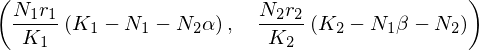

In [4]:
dN1_dt, dN2_dt

Usually one of the first things we do when analyzing a dynamical system is to find the steady state, i.e. finding when the derivative with respect to time equals to zero.

This as you must have guess is super simple to do with `sympy`.
We just have to define the equality using the `sympy.Eq` function.

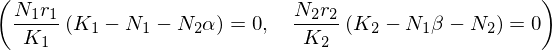

In [5]:
ss_N1 = sympy.Eq(dN1_dt, 0)
ss_N2 = sympy.Eq(dN2_dt, 0)
ss_N1, ss_N2

And now we just tell `sympy` to solve for the species population!

In [6]:
ss_N1_sol = sympy.solve(ss_N1, N1)
ss_N2_sol = sympy.solve(ss_N2, N2)
print('The steady state solution for both species are')
ss_N1_sol, ss_N2_sol

The steady state solution for both species are


So we find that there are two steady state solutions:
1. The trivial solutions in which both species are extinct to begin with, so $N_1 = N_2 = 0$
2. A solution in which both species maintain their non-zero populations.

Let's now be **super lazy** and assume we don't want to do the "trivial" algebra to find the exact solution for $N_1$ and $N_2$. We can use `sympy`'s `solve` function to solve simultaneously for both species.
The solution is returned as a dictionary where each key is the name of the variable

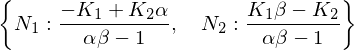

In [7]:
ss_dict = sympy.solve((sympy.Eq(N1, ss_N1_sol[1]), sympy.Eq(N2, ss_N2_sol[1])), (N1, N2))
ss_dict

We can use `scipy`'s numerical solver to run a simulation for this system of equations.

But in ordert to avoid rewriting the function I'll take the change to introduce the super powerful function `lambdify`.
`lambdify` takes a `sympy` symbolic expression and returns a function that can be either numerically or symbolically evaluated with other values.
This would allow us to evaluate and plot any nasty function that comes out of `sympy`'s powerful symbolic toolkit.

In [8]:
# Generate 'lambdify' functions to numerically evaluate the differential equations
dN1_dt_num = sympy.utilities.lambdify([N1, N2, r1, K1, alpha], dN1_dt)
dN2_dt_num = sympy.utilities.lambdify([N2, N1, r2, K2, beta], dN2_dt)


def lotka_voltera_rhs(n1n2, t, *p):
    '''
    Set up the right hand side (rhs) function for the system 
    (necessary step to feed sympy's odeint function).
    '''
    n1, n2 = n1n2 # unpack the variables
    r_1, k1, a, r_2, k2, b = p # unpack the parameters
    n1dot = dN1_dt_num(n1, n2, r_1, k1, a)
    n2dot = dN2_dt_num(n2, n1, r_2, k2, b)
    return np.array([n1dot, n2dot])

Now let's define the parameters and numerically solve the system

In [9]:
# let's set the parameter values.
r_1, r_2 = [0.5, 0.2]
n1n2_0 = [2, 2]  # Initial population size
k1, k2 = [100, 50]
a, b = [1.2, 0.2]
args = (r_1, k1, a, r_2, k2, b)
t = np.linspace(0, 100, 1000)

#Now let's use odeint to solve the function
n1n2 = odeint(lotka_voltera_rhs, n1n2_0, t, args=args)

We will now plot the solution.

But let's include the steady state solutions we previously found to see if indeed the populations are converging over time to this steady state.
For this we will simply use the `subs` function to replace the values that we chose for the parameters.

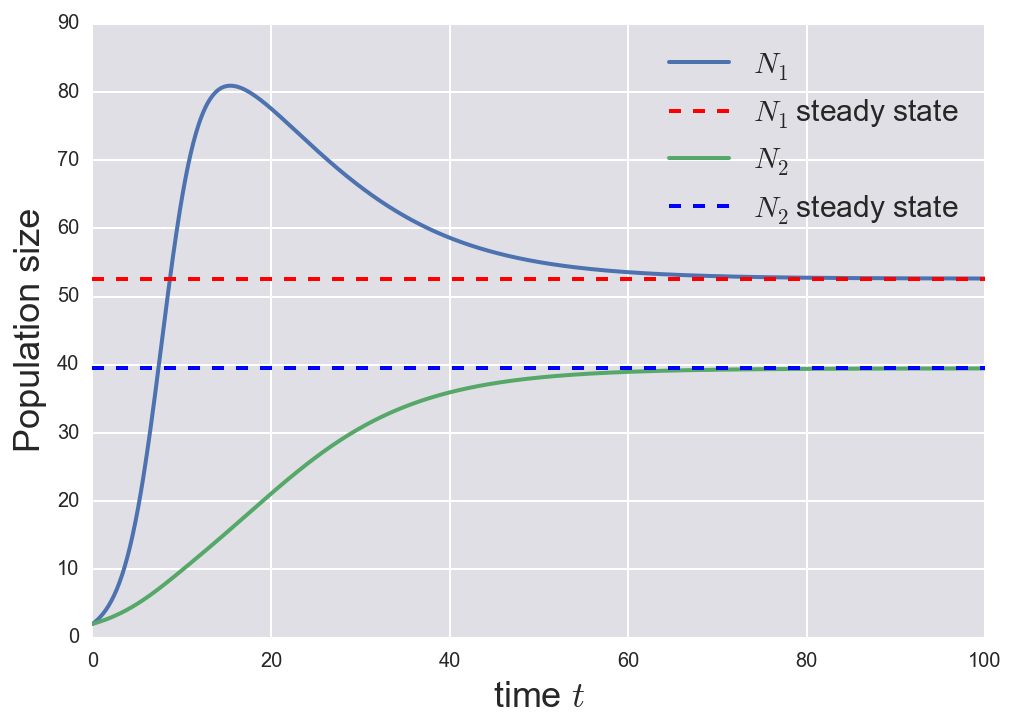

In [10]:
N_array = [N1, N2] #dummy list to loop through for the plot
color = ['r', 'b'] #dummy color list to color the steady state (annoying...)
for i in range(2):
    plt.plot(t, n1n2[:, i], label=r'$%s$'%sympy.latex(N_array[i]))
    plt.axhline(y=ss_dict[N_array[i]].subs({K1: k1, K2: k2, alpha: a, beta: b}),
                linestyle='--', color=color[i],
                label=r'$%s$ steady state'%sympy.latex(N_array[i]))

plt.legend(loc=0, fontsize=15)
plt.xlabel(r'time $t$')
plt.ylabel(r'Population size')

Just for fun let's make an interactive plot where we can change the parameters in real time and see how the dynamics change.

For this we will use the [interactive widgets](http://nbviewer.ipython.org/github/ipython/ipython/blob/2.x/examples/Interactive%20Widgets/Index.ipynb), another beauty possible in IPython.

In [11]:
def lotka_voltera_interactive(r_1, r_2, k1, k2, a, b):
    '''
    Function to generate an interactive plot where we can change
    the parameters of the ODE system.
    '''
    n1n2_0 = [2, 2]  # Initial population size
    args = (r_1, k1, a, r_2, k2, b)
    t = np.linspace(0, 100, 1000)
    #Now let's use odeint to solve the function
    n1n2 = odeint(lotka_voltera_rhs, n1n2_0, t, args=args)
    N_array = [N1, N2] #dummy list to loop through for the plot
    color = ['r', 'b'] #dummy color list to color the steady state
    fig = plt.figure()
    for i in range(2):
        plt.plot(t, n1n2[:, i], label=r'$%s$'%sympy.latex(N_array[i]))
        plt.axhline(y=ss_dict[N_array[i]].subs({K1: k1, K2: k2, alpha: a, beta: b}),
                    linestyle='--', color=color[i],
                    label=r'$%s$ steady state'%sympy.latex(N_array[i]))

    plt.legend(loc=0, fontsize=15)
    plt.xlabel(r'time $t$')
    plt.ylabel(r'Population size')
    plt.show()

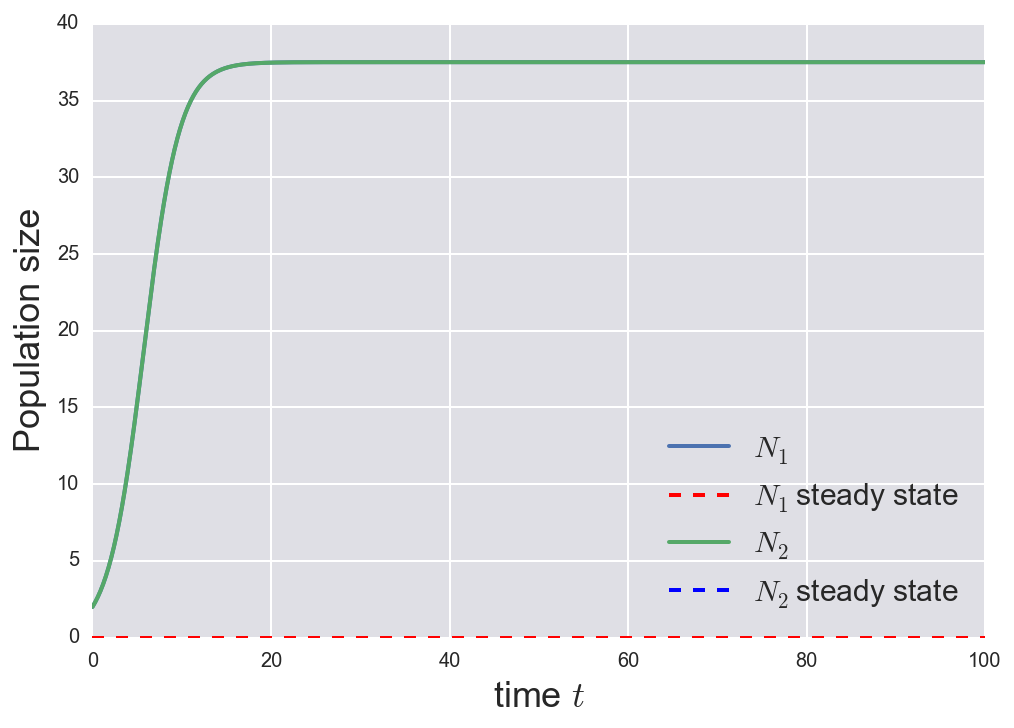

<function __main__.lotka_voltera_interactive>

In [12]:
interact(lotka_voltera_interactive,
         k1=(50, 100), k2=(50, 100),
         r_1=(0.1, 1, 0.1), r_2=(0.1, 1, 0.1),
         a=(0.1, 2, 0.1), b=(0.1, 2, 0.1))

# Probability distribution for catastrophe times

For this week's homework you are ask to derive the probability distribution for the catatrophy times of microtubules under the assumption that it is a multistep process with different rates $\tau_i$.

The final distribution has the form
\begin{align}
P(t\mid \boldsymbol{\tau}, m, I) = \sum_{j=1}^m \frac{\tau_j^{m-2}\,\mathrm{e}^{-t/\tau_j}}{\prod_{k=1,k\ne j}^m (\tau_j - \tau_k)}.
\end{align}

Let's say that we wanted to evaluate this function for a specific number of processes $m$. By the time you get to 4 processes you would be very tired of writing down the complete equation, not to say the pain that it would be to code it in Python!

Then, why don't we try to define this function in `sympy` and then use the power of `lambdify` to evaluate numerically the functions!

In [13]:
# define the variable for the time and the number of processes]
# We will also include the j and k from the product
t, m, k, j = sympy.symbols('t m k j')
def p_catastrophe(m=3):
    taus=sympy.symbols('tau:%d'%(m+1))[1:]
    p = list() # initialize list to keep sum terms
    for tau in taus:
        numerator = tau**(m - 2) * sympy.exp(- t / tau)
        denominator = list() # initialize list to keep denominator terms
        for tau_2 in taus:
            if tau_2 != tau:
                denominator.append(tau - tau_2)
        p.append(numerator / np.prod(denominator))
    return np.sum(p)

Let's look at some examples to see if it actually returns what we wanted

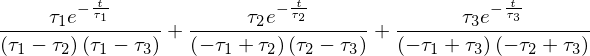

In [14]:
p_catastrophe(3)

Now lets look at an example we would never like to code by hand!

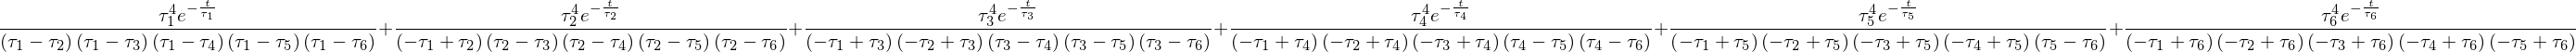

In [15]:
p_catastrophe(6)

I don't know about you guys, but I would never like to write manually this on a function in order to evaluate it.
That's why we'll make use of the power of `lambdify`!

In [16]:
def p_catastrophe_num(n, rates):
    '''
    Returns a lambdify function to evaluate numerically the probability of
    microtubule catastrophy as a function of the total time t.
    Parameters
    ----------
    n: int. number of processes involved in the microtubule catastrophe
    rates: array-like. numerical values of the processes rates. 
    
    warning: len(rates) must be equal to m!
    '''
    if len(rates) != n:
        raise ValueError('len(rates) must be equal to m!')
    # Generate dictionary to feed to subs function
    subs_dict = {key: value for (key, value) in\
                 zip(sympy.symbols('tau:%d'%(n+1))[1:], rates)}
    p = sympy.lambdify([t], p_catastrophe(n).subs(subs_dict), 'numpy')
    return p

Let's plot now the probability of microtubule catastrophy for some examples  with different number of processes!

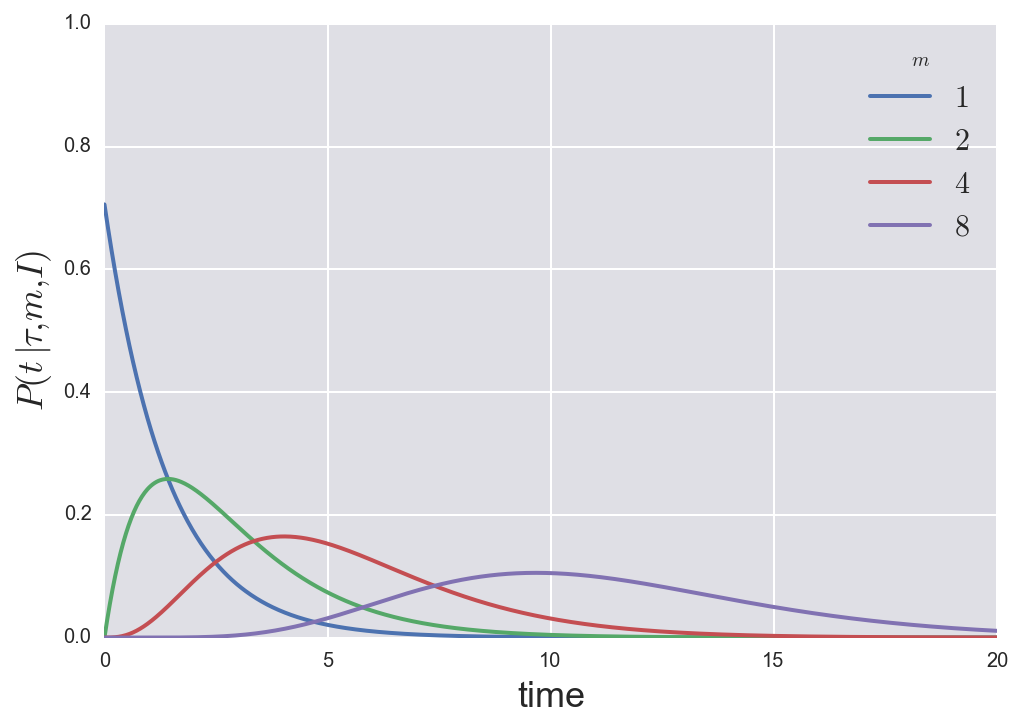

In [17]:
# Define the range of time to evaluate the function
time = np.linspace(0, 20, 1000)

# Define a random set of rates just to test the function
rates = np.random.rand(8) + 1

# List with the number of processes we want to plot
n_events = [1, 2, 4, 8]

# Loop through these events evaluating the function and ploting the resulting 
# probability distribution
for n in n_events:
    # Generate and evaluate function in a single line!
    prob = p_catastrophe_num(n, rates[0:n])(time)
    # Plot the distribution
    plt.plot(time, prob, label=r'$%d$'%n)
plt.legend(loc=0, fontsize=15, title='$m$')
plt.xlabel('time')
plt.ylim(0, 1)
plt.xlim(0, max(time))
plt.ylabel(r'$P(t\mid \mathbf{\tau}, m, I)$')